```markdown
# Visualisation
```

In [1]:
#functions
import networkx as nx
import matplotlib.pyplot as plt
import time
import numpy as np
from scipy.spatial.distance import pdist, squareform
from matplotlib.patches import FancyArrowPatch
#from model import generate_data, seq2seq_generate_tour,MambaFull, compute_tour_length
import torch
def compute_tour_length(x, tour,remove_start_token=True,get_tour_only=True,get_cumulative=False): 
    """
    Compute the length of a batch of tours
    Inputs : x of size (bsz, city_count+1, 2) batch of tsp tour instances
             tour of size (bsz, city_count) batch of sequences (node indices) of tsp tours
    Output : L of size (bsz,)             batch of lengths of each tsp tour
    """
    if remove_start_token:
        x = x[:,:-1,:]
    bsz = x.shape[0]
    arange_vec = torch.arange(bsz, device=x.device).unsqueeze(-1)
    tour = tour.to(x.device)

    # Get the cities in the order of the tour
    ordered_cities = x[arange_vec, tour, :] # size(ordered_cities)=(bsz, city_count, 2)

    # Compute the differences between each pair of consecutive cities
    diffs = ordered_cities[:, 1:, :] - ordered_cities[:, :-1, :] # size(diffs)=(bsz, city_count-1, 2)

    # Compute the distance between each pair of consecutive cities
    distances = torch.sqrt(torch.sum(diffs**2, dim=2)) # size(distances)=(bsz, city_count-1)

    # Add the distance from the last city to the first
    distances = torch.cat([distances, torch.norm(ordered_cities[:, 0, :] - ordered_cities[:, -1, :], dim=1).unsqueeze(-1)], dim=1)
    # Sum the distances to get the total length of each tour
    L = torch.sum(distances, dim=1)
    if get_cumulative:
        L = torch.cumsum(distances,dim=1).mean(0)
    if get_tour_only:
        return L
    #this will both return the tour and the length
    else:
        return L, distances

def plot_tsp_old(x_coord, x_path, plot_concorde=False, plot_dist_pair=False):
    """
    Helper function to plot TSP tours.
    """

    # pytorch detach
    x_coord = x_coord.detach().cpu()
    x_path = x_path.detach().cpu()
    
    # compute TSP lengths
    length_tsp = compute_tour_length(x_coord, x_path, remove_start_token=False)

    # preparation  
    x_coord = np.array(x_coord)
    x_path = np.array(x_path)
    nb_nodes = x_coord.shape[1]
    G = nx.from_numpy_array(np.zeros((nb_nodes,nb_nodes)))
    colors = ['g'] + ['b'] * (nb_nodes - 1)  # Green for 0th node, blue for others
    batch_size = x_coord.shape[0]
    max_nb_plots = 3**2 # max number of TSP plots, x^2 for x rows and x cols 
    nb_plots = batch_size if batch_size<max_nb_plots else max_nb_plots 
    nb_rows = nb_cols = int(nb_plots**0.5)
    if plot_concorde: nb_cols *= 2 # double nb of cols if concorde is plotted 
    f = plt.figure(figsize=(10, 5)) if plot_concorde else plt.figure(figsize=(15, 15)) # figure size  
    
    # gap
    running_time = 0
    gap = 0
    L_concorde = []
    
    # loop over TSPs
    for i in range(nb_plots):
        x_coord_i = x_coord[i]
        pos_i = dict(zip(range(len(x_coord_i)), x_coord_i.tolist()))
        if plot_dist_pair: # Compute pairwise distances matrix for better visualization
            dist_pair_i = squareform(pdist(x_coord_i, metric='euclidean')) 
            G = nx.from_numpy_array(dist_pair_i)
        x_path_i = x_path[i] 
        length_tsp_i = length_tsp[i]
        nodes_pair_tsp_i = []
        for r in range(nb_nodes-1): # compute consecutive nodes in the solution
            nodes_pair_tsp_i.append((x_path_i[r], x_path_i[r+1]))
        nodes_pair_tsp_i.append((x_path_i[nb_nodes-1], x_path_i[0]))
        if plot_concorde: # run concorde solver
            start = time.time()
            graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
            solver = TSPSolver.from_data( graph.lat, graph.lon, norm="GEO" )  
            solution = solver.solve().tour
            running_time += time.time()-start
            nodes_pair_concorde_i = []
            for r in range(nb_nodes-1):
                nodes_pair_concorde_i.append((solution[r], solution[r+1]))
            nodes_pair_concorde_i.append((solution[nb_nodes-1], solution[0]))
            length_concorde = compute_tour_length(torch.tensor(x_coord_i).unsqueeze(0),torch.tensor(solution).long().unsqueeze(0))
            gap += length_tsp_i/length_concorde - 1.0
            L_concorde.append(length_concorde)
        if plot_concorde:
            subf = f.add_subplot(nb_rows,nb_cols,2*i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
            subf = f.add_subplot(nb_rows,nb_cols,2*i+2)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_concorde_i, alpha=1, width=1, edge_color='b') #, style='dashed'
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ Concorde : ' + str(length_concorde.item())[:5])
        else:
            subf = f.add_subplot(nb_rows,nb_cols,i+1)
            nx.draw_networkx_nodes(G, pos_i, node_color=colors, node_size=20)
            nx.draw_networkx_edges(G, pos_i, edgelist=nodes_pair_tsp_i, alpha=1, width=1, edge_color='r')
            if plot_dist_pair:
                nx.draw_networkx_edges(G, pos_i, alpha=0.3, width=0.5)
            subf.set_title('Length w/ NNetwork : ' + str(length_tsp_i.item())[:5])
       

    
    # gap
    if plot_concorde:
        L_concorde = torch.stack(L_concorde).squeeze()
        print('L_concorde',L_concorde)
        print('Concorde time: {:.3f}sec'.format(running_time))  
        print('gap:',(gap/nb_plots).item())


def plot_tsp(x_coord, tours, probability=None, plot_dist_pair=False,save=None):
    """
    Helper function to plot a single TSP problem with four different tours.
    
    Args:
    x_coord (numpy.ndarray): Coordinates of cities, shape (n, 2)
    tours (list): List of 4 tours, each tour is a list/array of city indices
    probability (list, optional): List of 4 lists, each containing probabilities for the edges in the corresponding tour
    plot_dist_pair (bool): Whether to plot pairwise distances
    """
    names=['Mamba','Transformer','Optimal','Greedy']
    tours = [tour.tolist() for tour in tours]
    # Ensure x_coord is numpy array
    x_coord = np.array(x_coord)
    nb_nodes = x_coord.shape[0]
    
    # Create a graph
    G = nx.Graph()
    pos = dict(zip(range(nb_nodes), x_coord.tolist()))
    
    if plot_dist_pair:
        dist_pair = squareform(pdist(x_coord, metric='euclidean'))
        G = nx.from_numpy_array(dist_pair)
    else:
        G.add_nodes_from(range(nb_nodes))  # Ensure nodes are added to the graph
    
    # Create a 1x4 subplot
    fig, axs = plt.subplots(1, 3, figsize=(20, 8))
    axs = axs.ravel()
    
    for i, tour in enumerate(tours):
        if i==3:
            break
        # Compute tour length
        length = sum(np.linalg.norm(x_coord[tour[j]] - x_coord[tour[j-1]]) for j in range(nb_nodes))
        
        # Create edge list for the tour
        edges = list(zip(tour, tour[1:] + [tour[0]]))
        
        # Colors for nodes
        colors = ['b'] * nb_nodes  # Default color blue
        colors[tour[0]] = 'g'  # Green for the first node of the tour
        node_sizes = [80 if i == tour[0] else 30 for i in range(nb_nodes)]
        
        # Plot nodes
        nx.draw_networkx_nodes(G, pos, ax=axs[i], node_color=colors, node_size=node_sizes)
        
        # Plot edges with arrows and probabilities if provided
        for j, (u, v) in enumerate(edges):
            axs[i].add_patch(FancyArrowPatch(posA=pos[u], posB=pos[v], arrowstyle='->', color='r', mutation_scale=20))
            if probability is not None and probability[i] is not None:
                prob = probability[i][j]
                mid_point = (np.array(pos[u]) + np.array(pos[v])) / 2
                axs[i].text(mid_point[0], mid_point[1], f'{prob:.2f}', fontsize=10, color='black')
        
        if plot_dist_pair:
            nx.draw_networkx_edges(G, pos, ax=axs[i], alpha=0.08, width=0.5)
        
        axs[i].set_title(f'Tour {names[i]}: Length = {length:.3f}', fontsize=16)
        axs[i].axis('off')
    
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    plt.show()

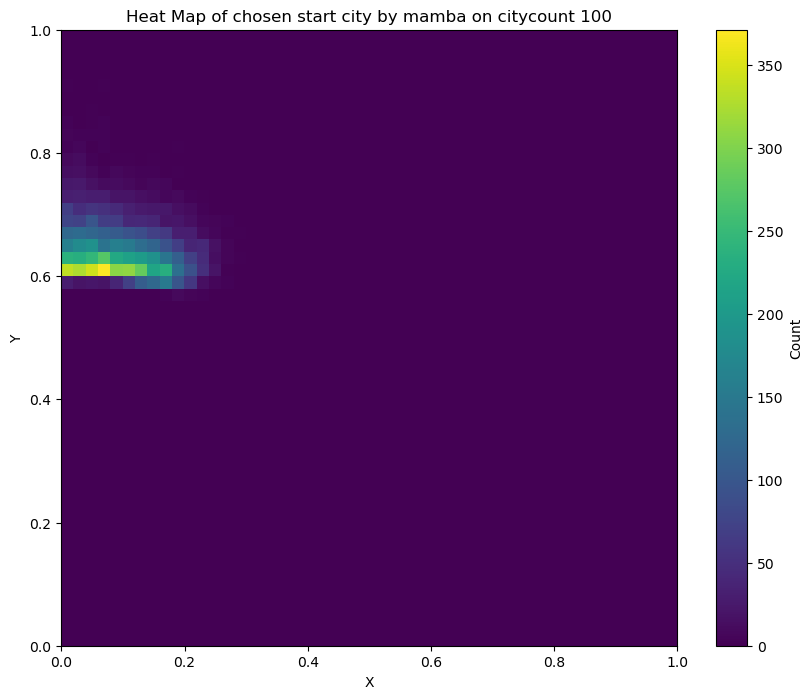

In [41]:
#Start token heatmap
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
import pandas as pd
import numpy as np
import torch
from benchmarks.benchmark_solvers import greedy_tsp
import numpy as np
import matplotlib.pyplot as plt
test_data = [] #(10000,50,2) (10000,100,2)
city_count = [50,100]
for i in range(2):
    test_data_loc=f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data.append(torch.load(test_data_loc))

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt',map_location=torch.device('cpu'))
tours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt',map_location=torch.device('cpu'))
probs_mamba = torch.load('evals/mamba_v_transformer/prob_of_action_mamba.pt',map_location=torch.device('cpu'))
probs_transformer = torch.load('evals/mamba_v_transformer/prob_of_action_transformer.pt',map_location=torch.device('cpu'))

test_data_labels = [] #(10000) (10000)
for k in range(2):
    test_data_label_loc = f'data/transformer_data/10k_TSP{city_count[k]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to('cpu'))

x=[]
y=[]

for i in range(10000):
    x.append(test_data[1][i][tours_mamba[1][i][0]][0].item())
    y.append(test_data[1][i][tours_mamba[1][i][0]][1].item())

# Create the heatmap
plt.figure(figsize=(10, 8))
heatmap, xedges, yedges = np.histogram2d(x, y, bins=50, range=[[0, 1], [0, 1]])
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
plt.colorbar(label='Count')

plt.title('Heat Map of chosen start city by mamba on citycount 100')
plt.xlabel('X')
plt.ylabel('Y')

# Set x and y limits to 0-1
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.savefig('evals/figs/analysis/start/mamba100.pdf')
plt.show()

Problem Name: 9275325d7ca84d5c93925ce01b2c088a
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1743
   0 Steps   Best: 1492   0.00 seconds
   1 Steps   Best: 1491   0.00 seconds
   2 Steps   Best: 1478   0.00 seconds
  50 Total Steps.
Best cycle length: 1478
Lin-Kernighan Running Time: 0.01
LK Initial Run: 1478.0
LK Run 0: 1478.0
LK Run from best tour: 1478.0
Time to find compression tour: 0.05 (seconds)
Set initial upperbound to 1478 (from tour)
Fractional Matching: 1440.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1478.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  135 columns  270 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1440.500000
Setting tolerances: next cu

100%|██████████| 100/100 [00:00<00:00, 240.84it/s]


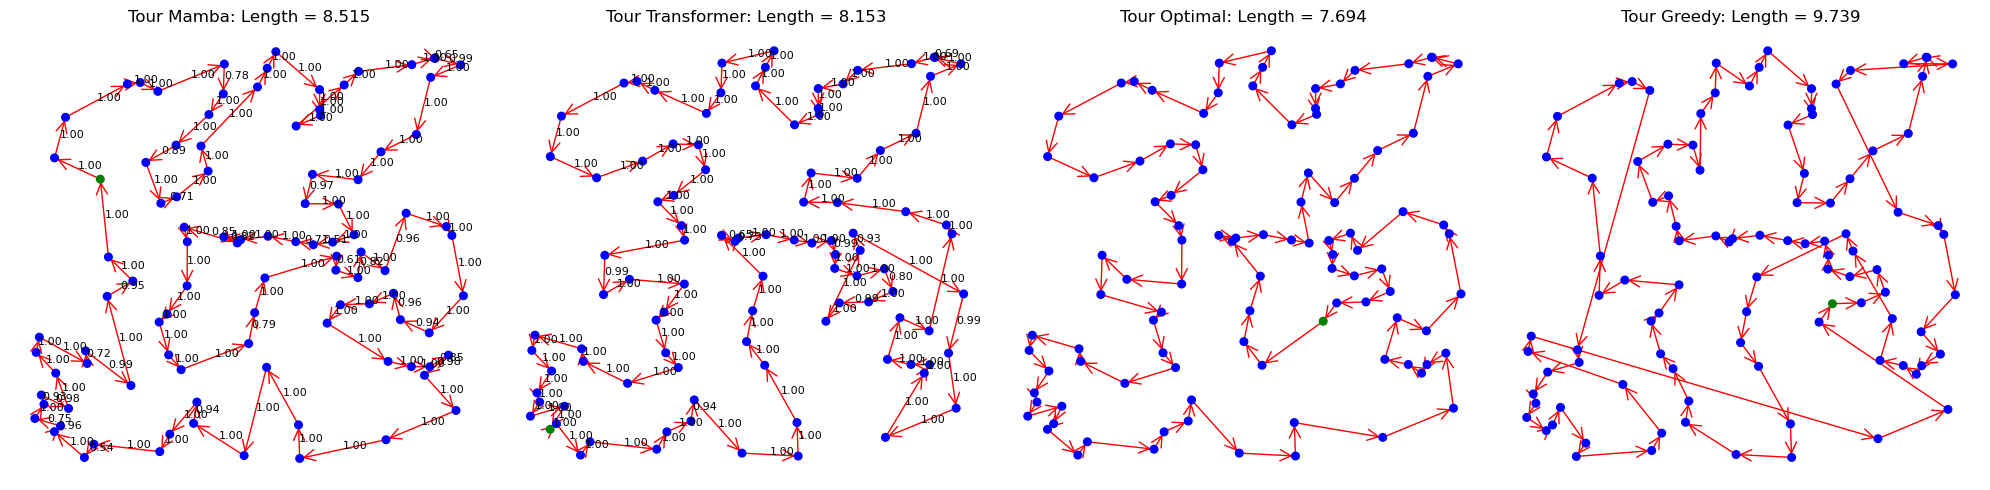

Problem Name: 0c71dbb93fde4df0baf838dad4ded9ac
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
torch.Size([100])
linkern ...
Setting kick type to close
Starting Cycle: 1887
   0 Steps   Best: 1493   0.00 seconds
   2 Steps   Best: 1491   0.00 seconds
  50 Total Steps.
Best cycle length: 1491
Lin-Kernighan Running Time: 0.03
LK Initial Run: 1491.0
LK Run 0: 1491.0
LK Run from best tour: 1491.0
Time to find compression tour: 0.12 (seconds)
Set initial upperbound to 1491 (from tour)
Fractional Matching: 1472.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1491.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  134 columns  268 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1472.500000
Setting tolerances: next cuts 0.1850 next round 

  8%|▊         | 8/100 [00:00<00:01, 73.84it/s]

econds)
Found  1 segment cuts in 0.00 seconds
  Add  1 cuts (Total 8), LP: 1461.000000 (0.00 seconds)
Found  2 Fast Blossoms in 0.00 seconds
  Add  2 cuts (Total 10), LP: 1462.250000 (0.00 seconds)
Found  2 Groetschel-Holland Blossoms in 0.00 seconds
  Add  2 cuts (Total 12), LP: 1465.666667 (0.00 seconds)
Block Combs
  Type 0: 1 cuts  0.6667 max violation  0.00 seconds
  Type 1: 1 cuts  0.6667 max violation  0.00 seconds
  Type 2: 1 cuts  0.6667 max violation  0.00 seconds
  Type 3: 0 cuts  0.0000 max violation  0.00 seconds
  Type 4: 0 cuts  0.0000 max violation  0.00 seconds
  Type 5: 0 cuts  0.0000 max violation  0.00 seconds
  Olaf 1: 0 cuts  0.0000 max violation  0.00 seconds
  Olaf 2: 0 cuts  0.0000 max violation  0.00 seconds
  Olaf 3: 0 cuts  0.0000 max violation  0.00 seconds
  Olaf 4: 0 cuts  0.0000 max violation  0.00 seconds
  Total Time in block_combs: 0.00
Found  3 block_combs in 0.00 seconds
  Add  3 cuts (Total 13), LP: 1467.500000 (0.00 seconds)
Found  1 exact subtour

100%|██████████| 100/100 [00:00<00:00, 135.17it/s]


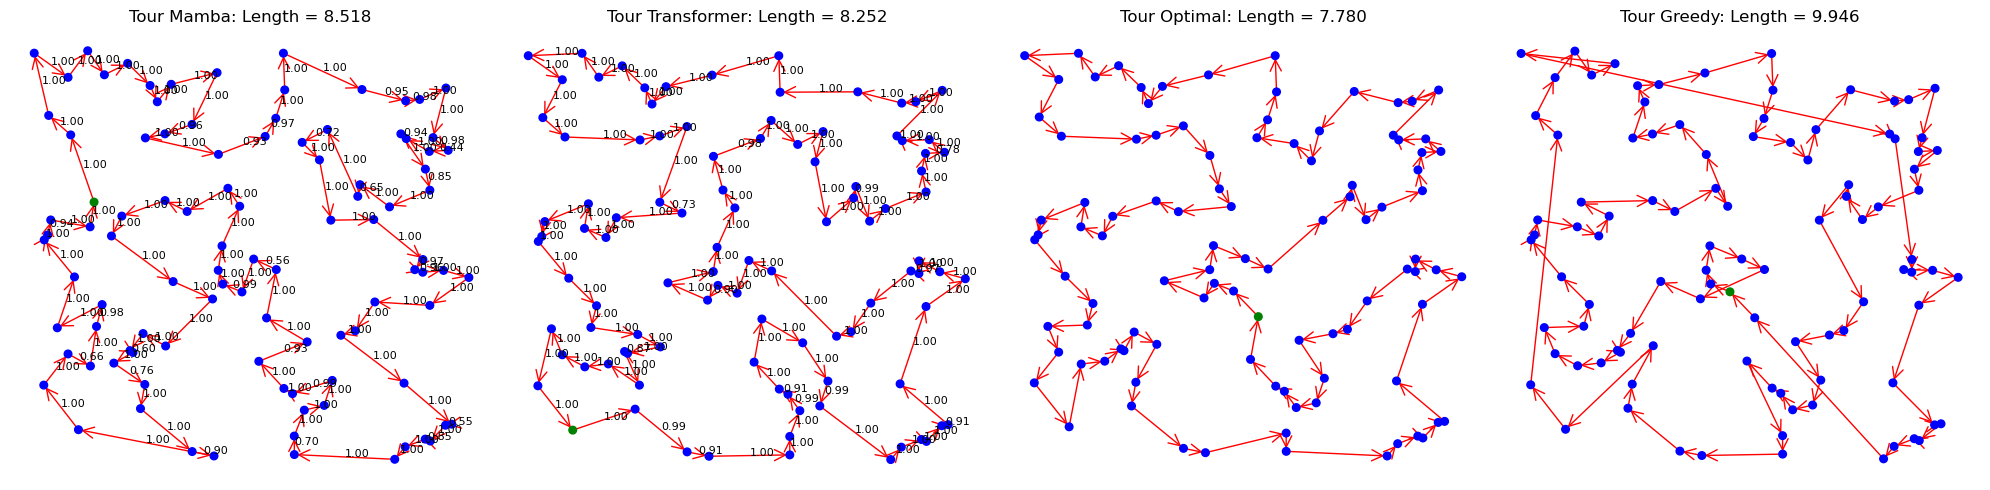

Problem Name: 866ffcd9c1f741f9a5097541a51f6da9
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...torch.Size([100])

Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1713
   0 Steps   Best: 1520   0.00 seconds
  50 Total Steps.
Best cycle length: 1520
Lin-Kernighan Running Time: 0.03
LK Initial Run: 1520.0
LK Run 0: 1517.0
LK Run from best tour: 1517.0
Time to find compression tour: 0.14 (seconds)
Set initial upperbound to 1517 (from tour)
Fractional Matching: 1470.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.01 (seconds)
Setting upperbound to the initial bound: 1517.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  133 columns  266 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1470.500000
Setting tolerances: next cuts 0.4650 next round 0.0465
CCtsp_init_edgegenerator (50)
Us

100%|██████████| 100/100 [00:00<00:00, 159.01it/s]


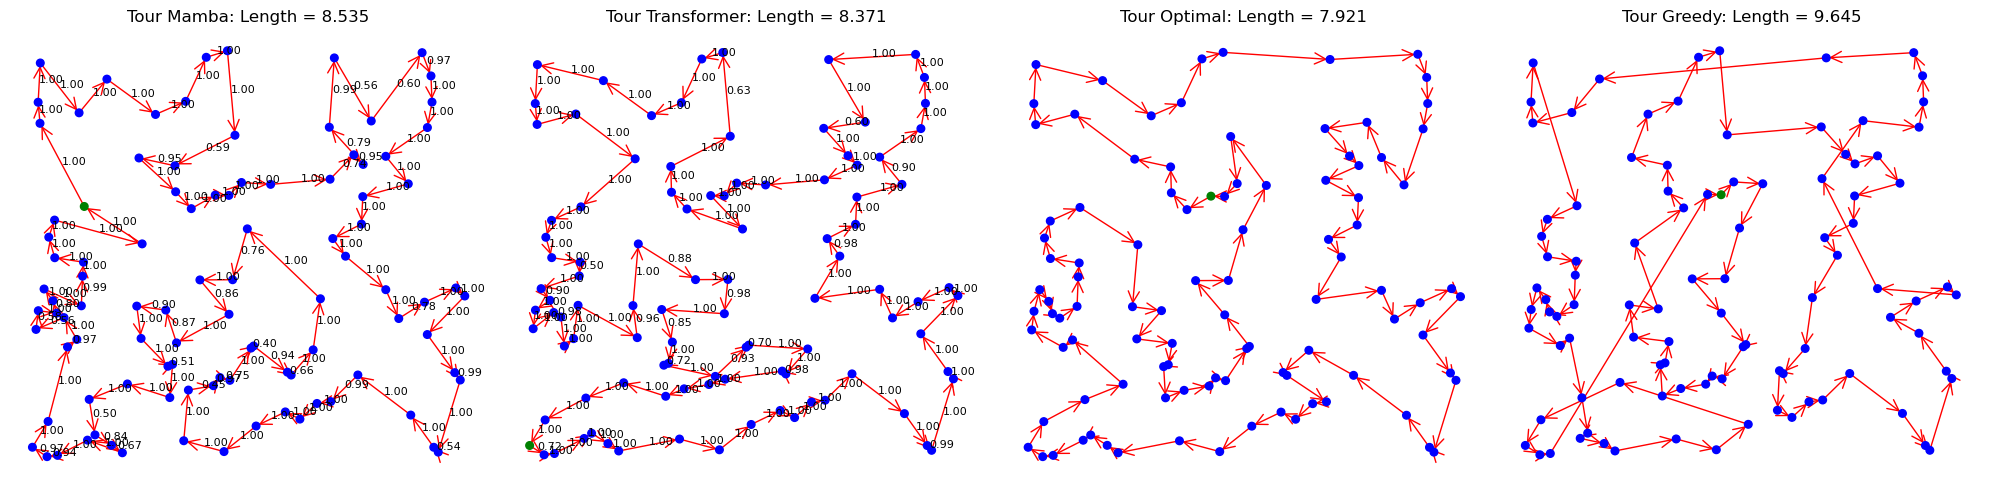

In [57]:
#Analysis mamba_better
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
import pandas as pd
import numpy as np
import torch
from benchmarks.benchmark_solvers import greedy_tsp
test_data = [] #(10000,50,2) (10000,100,2)
city_count = [50,100]
test_data_labels = [] #(10000) (10000)
city_count = [50,100]
for i in range(2):
    test_data_label_loc = f'data/transformer_data/10k_TSP{city_count[i]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to('cpu'))
for i in range(2):
    test_data_loc=f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data.append(torch.load(test_data_loc))

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

Loss_mamba = torch.load('evals/mamba_v_transformer/Loss_mamba.pt',map_location=torch.device('cpu'))
Loss_transformer = torch.load('evals/mamba_v_transformer/Loss_transformer.pt',map_location=torch.device('cpu'))
tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt',map_location=torch.device('cpu'))
tours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt',map_location=torch.device('cpu'))
probs_mamba = torch.load('evals/mamba_v_transformer/prob_of_action_mamba.pt',map_location=torch.device('cpu'))
probs_transformer = torch.load('evals/mamba_v_transformer/prob_of_action_transformer.pt',map_location=torch.device('cpu'))

mamba_better = [[],[]]
transformer_better=[[],[]]
transformer_much_better = [[],[]]
transformer_much_better_threshold = [0.9,1.4]
mamba_much_better = [[],[]]
mamba_much_better_threshold = [0.1,0.12]
both_far_from_optimal = [[],[]]
both_far_from_optimal_threshold = [0.18,0.45]
both_achieving_optimal = [[],[]]
for k in range(2):
    for num,(i,j)in enumerate(zip(Loss_mamba[k],Loss_transformer[k])):
        if i<j:
            mamba_better[k].append(num)
        else:
            transformer_better[k].append(num)
        if i>j+transformer_much_better_threshold[k]:
            transformer_much_better[k].append(num)
        if j>i+mamba_much_better_threshold[k]:
            mamba_much_better[k].append(num)
        if test_data_labels[k][num] - i == 0 and test_data_labels[k][num] - j == 0:
            both_achieving_optimal[k].append(num)
        if i - test_data_labels[k][num] > both_far_from_optimal_threshold[k] and j - test_data_labels[k][num] > both_far_from_optimal_threshold[k]:
            both_far_from_optimal[k].append(num)

for index,num in enumerate(both_far_from_optimal[1]):
    i,j = 1,num
    saveloc = f'evals/figs/analysis/far_from_optimal/100_{index+1}.pdf'
    x_coord_i = test_data[i][j]


    #print(torch.exp(probs_mamba[i][:,j]))
    #print(torch.exp(probs_transformer[i][:,j]).sum())
    print(create_concorde_tour(x_coord_i).shape)
    plot_tsp(x_coord_i, 
            [tours_mamba[i][j], tours_transformer[i][j], create_concorde_tour(x_coord_i), greedy_tsp(x_coord_i,remove_start_token=False)[1][0]],
            [torch.exp(probs_mamba[i][:,j]), torch.exp(probs_transformer[i][:,j]), None, None],save=saveloc)

torch.Size([10000, 50])
torch.Size([10000, 50])
[0]
[0]
tensor([5.8474, 5.8204, 5.8657,  ..., 6.1809, 6.1761, 6.0313])
50


100%|██████████| 50/50 [13:01<00:00, 15.62s/it]


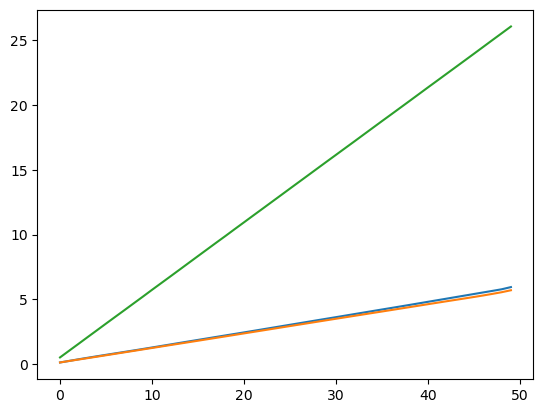

'print(tours)\n\nprint(create_concorde_tour(x_coord_i).shape)\nplot_tsp(x_coord_i, \n        [tours_mamba[i][j], tours_transformer[i][j], create_concorde_tour(x_coord_i), greedy_tsp(x_coord_i,remove_start_token=False)[1][0]],\n        [torch.exp(probs_mamba[i][:,j]), torch.exp(probs_transformer[i][:,j]), None, None],save=saveloc)'

In [89]:
#Greedyness scale
#Analysis mamba_better
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
import pandas as pd
import numpy as np
import torch
from benchmarks.benchmark_solvers import greedy_tsp
test_data = [] #(10000,50,2) (10000,100,2)
city_count = [50,100]
test_data_labels = [] #(10000) (10000)

for i in range(2):
    test_data_loc=f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data.append(torch.load(test_data_loc))

def create_concorde_tour(test_data):
    x_coord_i = test_data.cpu().numpy()
    graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
    solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
    solution = solver.solve()
    return torch.tensor(solution.tour)

tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt',map_location=torch.device('cpu'))
tours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt',map_location=torch.device('cpu'))

print(tours_mamba[0].shape)
print(tours_transformer[0].shape)

dist_m=[[0],[0]]
dist_t=[[0],[0]]


'''for i in range(1,100):
    dist_m[1].append((tours_mamba[1][:,i].mean()-tours_mamba[1][:,i-1].mean())+dist_m[1][-1])
    dist_t[1].append((tours_transformer[1][:,i].mean()-tours_transformer[1][:,i-1].mean())+dist_t[1][-1])
'''
print(dist_m[0])
print(dist_t[0])
print(compute_tour_length(test_data[0],tours_transformer[0],remove_start_token=False))
plt.plot(compute_tour_length(test_data[0],tours_mamba[0],remove_start_token=False,get_cumulative=True),label='Mamba')
plt.plot(compute_tour_length(test_data[0],tours_transformer[0],remove_start_token=False,get_cumulative=True),label='Transformer')
plt.plot(compute_tour_length(test_data[0],greedy_tsp(test_data[0],remove_start_token=False)[1][0],remove_start_token=False,get_cumulative=True),label='Greedy')
plt.show()

'''print(tours)

print(create_concorde_tour(x_coord_i).shape)
plot_tsp(x_coord_i, 
        [tours_mamba[i][j], tours_transformer[i][j], create_concorde_tour(x_coord_i), greedy_tsp(x_coord_i,remove_start_token=False)[1][0]],
        [torch.exp(probs_mamba[i][:,j]), torch.exp(probs_transformer[i][:,j]), None, None],save=saveloc)'''

In [64]:
#Transformer parameter count
from benchmarks.transformer_model import TSP_net
import torch
import matplotlib.pyplot as plt
nb_nodes = 100 # TSP100
dim_emb = 128
dim_ff = 512
dim_input_nodes = 2
nb_layers_encoder = 6
nb_layers_decoder = 2
nb_heads = 8
max_len_PE = 1000
batchnorm = True
device = 'cpu'

TSP_model = TSP_net(dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,batchnorm).to(device)
TSP_model.eval()
print('Total number of parameters:', sum(p.numel() for p in TSP_model.parameters()))
if nb_nodes == 50:
    checkpoint = torch.load('benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl',map_location=torch.device('cpu'))
elif nb_nodes == 100:
    checkpoint = torch.load('benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl',map_location=torch.device('cpu'))
epoch_ckpt = checkpoint['epoch'] + 1
tot_time_ckpt = checkpoint['tot_time']
plot_performance_train = checkpoint['plot_performance_train']
plot_performance_baseline = checkpoint['plot_performance_baseline']
print(tot_time_ckpt/60/60/24) #50 == 20.89, 100==26.86

Total number of parameters: 1405568
26.863704100118742


```markdown
# Calculate Benchmarks
```

In [2]:
#Test our best mamba model and transformer solver on 10k test set
import torch
from model import seq2seq_generate_tour,MambaFull, compute_tour_length
from benchmarks.transformer_model import TSP_net
#from benchmarks.benchmark_solvers import greedy_tsp

coord_dim = 2
city_count = [50,100]
test_size=10000
device = 'cuda'

class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

test_data = [] #(10000,50,2) (10000,100,2)
test_data_with_start = [] #(10000,51,2) (10000,101,2)
test_data_labels = [] #(10000) (10000)

for i in range(2):
    test_data_loc=f'mamba/data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data_tmp = torch.load(test_data_loc).to(device)
    start_data = torch.full((test_size, 1, coord_dim), 2).to(device)
    test_data_tmp2 = torch.cat((test_data_tmp, start_data), dim=1)
    test_data.append(test_data_tmp)
    test_data_with_start.append(test_data_tmp2)

    test_data_label_loc = f'mamba/data/transformer_data/10k_TSP{city_count[i]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to(device))



#Greedy resutls on transformer test set: 6.99 & 9.6862
'''for i in range(len(city_count)):
    print(test_data[i].shape)
    print(test_data_with_start[i].shape)
    print(greedy_tsp(test_data_with_start[i])[0]) #Greedy'''

checkpoints = [torch.load('mamba/checkpoints/big/share_50_big_fix_2.pt'),
               torch.load('mamba/checkpoints/big/BIG_city100_2.pt')]
transformer_checkpoints = [torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl'),
                           torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl')]

transformer_model = TSP_net(2, 128, 512, 6, 2, 8, 1000,True).to(device)
transformer_model.eval()

Loss_mamba = [] #(10000) (10000)
Loss_transformer = [] #(10000) (10000)
tours_mamba = [] #(10000,50) (10000,100)
tours_transformer = [] #(10000,50) (10000,100)
prob_of_action_mamba = [] #(10000,50) (10000,100)
prob_of_action_transformer = [] #(10000,50) (10000,100)

for i, (checkpoint_m, checkpoint_t) in enumerate(zip(checkpoints, transformer_checkpoints)):
    
    args = checkpoint_m['args']
    model = MambaFull(args.d_model, args.city_count, args.nb_layers, args.coord_dim, args.mlp_cls,args.B, args.reverse,args.reverse_start,args.mamba2,args.last_layer).to(device)
    model.load_state_dict(checkpoint_m['model_baseline_state_dict'])
    model.eval()
    if i==0:
        print('CITY 50')
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])
    else:
        print('CITY 100')
        checkpoint_t['model_baseline'] = {k.replace('module.', ''): v for k, v in checkpoint_t['model_baseline'].items()}
        transformer_model.load_state_dict(checkpoint_t['model_baseline'])

    with torch.no_grad():
        tours ,Logprobofactions = seq2seq_generate_tour(device,model,test_data_with_start[i],deterministic=True,lastlayer=args.last_layer,sum_logactions=False)
        tours_mamba.append(tours)
        print(len(Logprobofactions))
        print(Logprobofactions[0].shape)
        prob_of_action_mamba.append(torch.stack(Logprobofactions, dim=0))
        Loss_mamba.append(compute_tour_length(test_data_with_start[i],tours_mamba[i]))
        print(tours_mamba[i].shape)
        print('Loss:',Loss_mamba[i].mean())

        tours, Logprobofactions = transformer_model(test_data[i],True,sum_logactions=False)
        tours_transformer.append(tours)
        print(len(Logprobofactions))
        print(Logprobofactions[0].shape)
        prob_of_action_transformer.append(torch.stack(Logprobofactions, dim=0))
        Loss_transformer.append(compute_tour_length(test_data[i],tours_transformer[i],remove_start_token=False))
        print(tours_transformer[i].shape)
        print('Loss Transformer:',Loss_transformer[i].mean())

mamba_better = [0,0]
transformer_better=[0,0]
for k in range(2):
    for i,j in zip(Loss_mamba[k],Loss_transformer[k]):
        if i<=j:
            mamba_better[k]+=1
        else:
            transformer_better[k]+=1
print('mamba better  ',mamba_better,', transformer better  ', transformer_better)

torch.save(Loss_mamba, 'mamba/evals/mamba_v_transformer/Loss_mamba.pt')
torch.save(Loss_transformer, 'mamba/evals/mamba_v_transformer/Loss_transformer.pt')
torch.save(tours_mamba, 'mamba/evals/mamba_v_transformer/tours_mamba.pt')
torch.save(tours_transformer, 'mamba/evals/mamba_v_transformer/tours_transformer.pt')
torch.save(prob_of_action_mamba, 'mamba/evals/mamba_v_transformer/prob_of_action_mamba.pt')
torch.save(prob_of_action_transformer, 'mamba/evals/mamba_v_transformer/prob_of_action_transformer.pt')

CITY 50
50
torch.Size([10000])
torch.Size([10000, 50])
Loss: tensor(5.9469, device='cuda:0')
50
torch.Size([10000])
torch.Size([10000, 50])
Loss Transformer: tensor(5.7036, device='cuda:0')
CITY 100
100
torch.Size([10000])
torch.Size([10000, 100])
Loss: tensor(8.3628, device='cuda:0')
100
torch.Size([10000])
torch.Size([10000, 100])
Loss Transformer: tensor(7.8754, device='cuda:0')
mamba better   [106, 25] , transformer better   [9894, 9975]


torch.Size([10000])
torch.Size([10000])
tensor([6.0618, 5.9124, 6.2793, 5.8556, 6.7740])
tensor([5.8474, 5.8204, 5.8657, 5.5537, 5.9738])
tensor([5.8300, 5.7980, 5.8467, 5.5440, 5.9738])
torch.Size([10000])
torch.Size([10000])
tensor([8.2844, 7.7704, 8.7856, 8.0017, 7.9411])
tensor([7.8370, 7.6335, 8.1019, 7.7210, 7.2976])
tensor([7.7014, 7.4563, 7.9338, 7.5602, 7.2130])


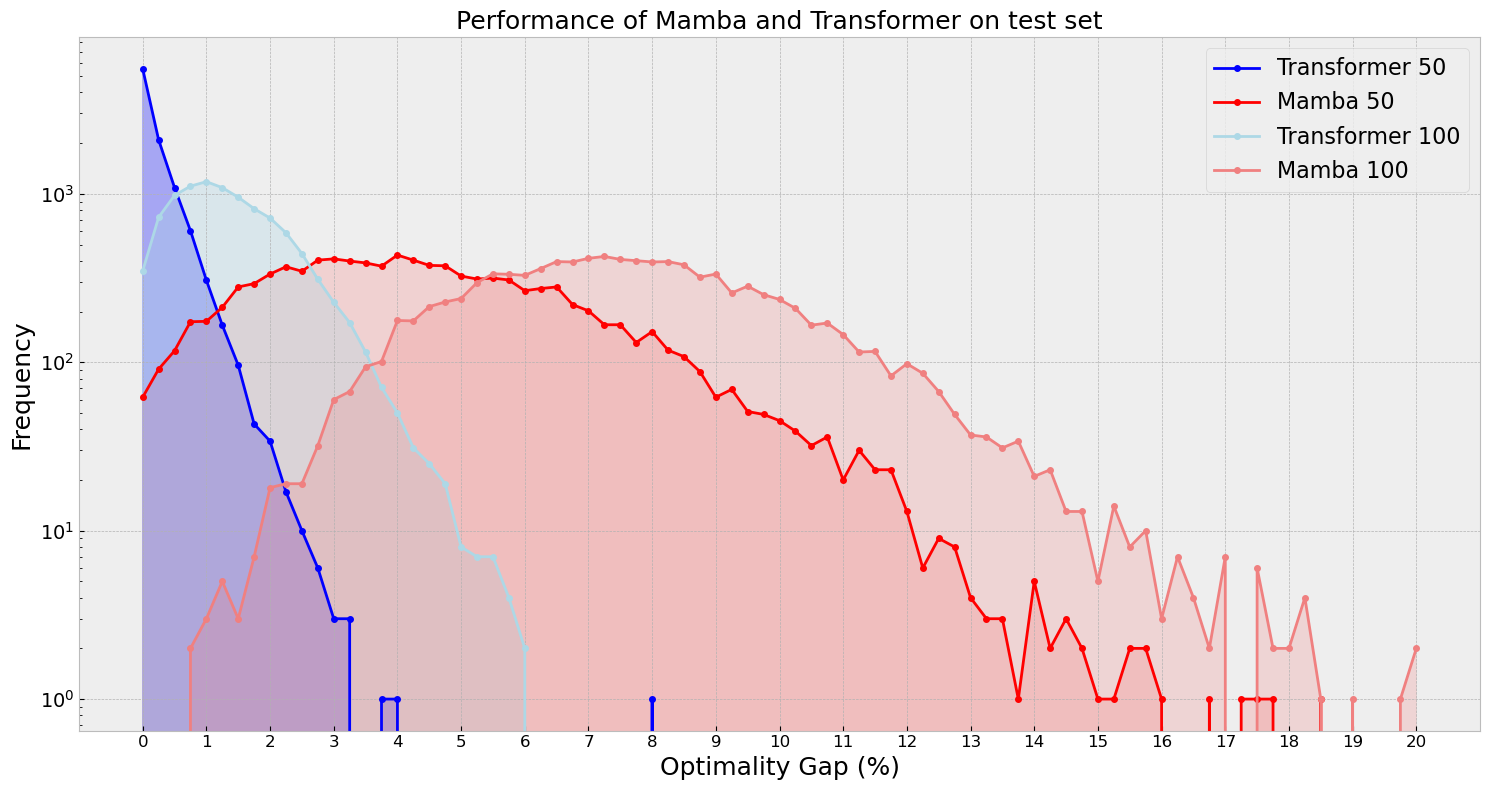

In [126]:
#Histogram
import numpy as np
import matplotlib.pyplot as plt
import torch

#import lossmamba and transformer
Loss_mamba = torch.load('evals/mamba_v_transformer/Loss_mamba.pt',map_location=torch.device('cpu'))
Loss_transformer = torch.load('evals/mamba_v_transformer/Loss_transformer.pt',map_location=torch.device('cpu'))
test_data_labels = [] #(10000) (10000)
city_count = [50,100]
for i in range(2):
    test_data_label_loc = f'data/transformer_data/10k_TSP{city_count[i]}_len.pt'
    test_data_labels.append(torch.load(test_data_label_loc).to('cpu'))


'''mamba_better = [[],[]]
transformer_better=[[],[]]
transformer_much_better = [[],[]]
transformer_much_better_threshold = [0.9,1.4]
mamba_much_better = [[],[]]
mamba_much_better_threshold = [0.1,0.12]
both_far_from_optimal = [[],[]]
both_far_from_optimal_threshold = [0.18,0.45]
both_achieving_optimal = [[],[]]
for k in range(2):
    for num,(i,j)in enumerate(zip(Loss_mamba[k],Loss_transformer[k])):
        if i<j:
            mamba_better[k].append(num)
        else:
            transformer_better[k].append(num)
        if i>j+transformer_much_better_threshold[k]:
            transformer_much_better[k].append(num)
        if j>i+mamba_much_better_threshold[k]:
            mamba_much_better[k].append(num)
        if test_data_labels[k][num] - i == 0 and test_data_labels[k][num] - j == 0:
            both_achieving_optimal[k].append(num)
        if i - test_data_labels[k][num] > both_far_from_optimal_threshold[k] and j - test_data_labels[k][num] > both_far_from_optimal_threshold[k]:
            both_far_from_optimal[k].append(num)

print('city 50')
print('mamba better  ',len(mamba_better[0]),', transformer better  ', len(transformer_better[0]),', transformer much better  ', len(transformer_much_better[0]),', mamba much better  ', len(mamba_much_better[0]))
print('both far from optimal  ', len(both_far_from_optimal[0]),', both achieving optimal  ', len(both_achieving_optimal[0]))
print('city 100')
print('mamba better  ',len(mamba_better[1]),', transformer better  ', len(transformer_better[1]),', transformer much better  ', len(transformer_much_better[1]),', mamba much better  ', len(mamba_much_better[1]))
print('both far from optimal  ', len(both_far_from_optimal[1]),', both achieving optimal  ', len(both_achieving_optimal[1]))
'''
#Convert loss to optimality gap
for i in range(2):
    print(Loss_mamba[i].shape)
    print(Loss_transformer[i].shape)
    print(Loss_mamba[i][:5])
    print(Loss_transformer[i][:5])
    print(test_data_labels[i][:5])
    Loss_mamba[i] = (Loss_mamba[i] - test_data_labels[i])*100/test_data_labels[i]
    Loss_transformer[i] = (Loss_transformer[i] - test_data_labels[i])*100/test_data_labels[i]

plt.style.use('bmh')



for i in range(1):
    # Define custom bin edges according to the specification
    bin_edges = np.concatenate([
        [-np.inf],  # For bin 0
        np.arange(0.125, 20, 0.25),  # For bins 1 to second last
        [np.inf]  # For the last bin
    ])

    # Create histogram data
    hist1, _ = np.histogram(Loss_transformer[i].numpy(), bins=bin_edges)
    hist2, _ = np.histogram(Loss_mamba[i].numpy(), bins=bin_edges)

    i+=1

    hist3, _ = np.histogram(Loss_transformer[i].numpy(), bins=bin_edges)
    hist4, _ = np.histogram(Loss_mamba[i].numpy(), bins=bin_edges)

    # Set up the plot
    fig, ax = plt.subplots(figsize=(15, 8))

    # Set the positions of the points on the x-axis
    r = np.arange(len(hist1))

    # Create the line chart
    # Plot the 50 variant
    ax.plot(r, hist1, marker='o', markersize=4, color='blue', label='Transformer 50')
    ax.plot(r, hist2, marker='o', markersize=4, color='red', label='Mamba 50')
    ax.plot(r, hist3, marker='o', markersize=4, color='lightblue', label='Transformer 100')
    ax.plot(r, hist4, marker='o', markersize=4, color='lightcoral', label='Mamba 100')
    ax.fill_between(r, hist1,color='blue', alpha=0.3)
    ax.fill_between(r, hist2,color='red', alpha=0.12)
    ax.fill_between(r, hist3,color='lightblue', alpha=0.32)
    ax.fill_between(r, hist4,color='lightcoral', alpha=0.23)

    # Customize the plot
    ax.set_xlabel('Optimality Gap (%)', fontsize=18)
    ax.set_ylabel('Frequency', fontsize=18)
    ax.set_title(f'Performance of Mamba and Transformer on test set', fontsize=18)

    # Identify the bins corresponding to whole numbers and set the labels
    whole_number_bins = [0] + [int((x + 0.125) * 4) for x in range(1, 20)] + [len(bin_edges) - 2]
    whole_number_labels = list(range(21))
    
    ax.set_xticks(whole_number_bins)
    ax.set_xticklabels(whole_number_labels, fontsize=12)
    plt.yticks(fontsize=14)
    
    ax.legend(fontsize=16)
    ax.set_yscale('log')
    ax.x_lim = (0, 20)

    # Adjust layout and show the plot
    plt.tight_layout()

    # Uncomment to save the plot
    save_loc = f'evals/mamba_v_transformer/combined.pdf'
    plt.savefig(save_loc, bbox_inches='tight')

    plt.show()

Concorde

Problem Name: 5c12685fe9534ee8bf4c3bebebc58942
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1856
   0 Steps   Best: 1579   0.00 seconds
  10 Steps   Best: 1576   0.02 seconds
  50 Total Steps.
Best cycle length: 1576
Lin-Kernighan Running Time: 0.04
LK Initial Run: 1576.0
LK Run 0: 1572.0
LK Run from best tour: 1572.0
Time to find compression tour: 0.13 (seconds)
Set initial upperbound to 1572 (from tour)
Fractional Matching: 1535.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1572.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  154 columns  308 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1535.000000
Setting tolerances: next cuts 0.3700 next round 0.0370
CCtsp_init_

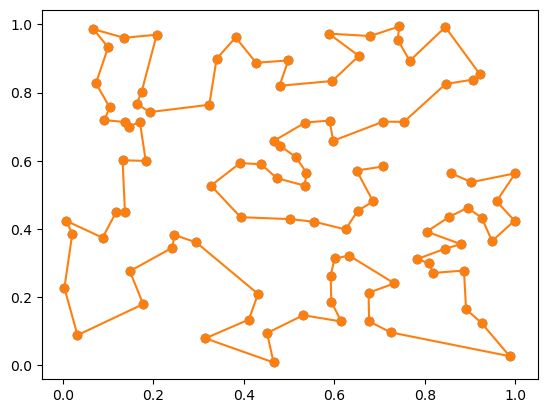

1572.0


In [2]:
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
from benchmarks.pyconcorde.concorde.tests.data_utils import get_dataset_path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
x_coord_i = np.random.rand(100,2)
plt.plot(x_coord_i[:,0],x_coord_i[:,1],'o')
graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]

# Solve the TSP problem
solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
solution = solver.solve()

# Plot the tour
plt.plot(x_coord_i[solution.tour, 0], x_coord_i[solution.tour, 1], 'o-')

# Display the plot
plt.show()
print(solution.optimal_value)

In [2]:
#Create concorde tours on test set
from benchmarks.pyconcorde.concorde.tsp import TSPSolver
import pandas as pd
import numpy as np
import torch
test_data = [] #(10000,50,2) (10000,100,2)
city_count = [50,100]
for i in range(2):
    test_data_loc=f'data/transformer_data/10k_TSP{city_count[i]}.pt'
    test_data.append(torch.load(test_data_loc))
    test_data[i] = test_data[i].cpu().numpy()

tours_concorde = []
for i in range(2):
    tours = []
    for b in range(1):
        x_coord_i = test_data[i][b]
        graph =  pd.DataFrame({'lat' : x_coord_i[:,0]}); graph['lon'] =  x_coord_i[:,1]
        # Solve the TSP problem
        solver = TSPSolver.from_data(graph.lat, graph.lon, norm="GEO")
        solution = solver.solve()
        tours.append(torch.tensor(solution.tour))
    torch.stack(tours)
    tours_concorde.append(tours)
#torch.save(tours_concorde, 'evals/mamba_v_transformer/tours_concorde.pt')


'''tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt',map_location=torch.device('cpu'))
tours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt',map_location=torch.device('cpu'))
print(tours_mamba[0][0].shape,tours_transformer[0][0].shape)'''

100%|██████████| 1/1 [00:00<00:00, 11.15it/s]


Problem Name: 42ba2a441eb445198d4770aaaf778428
Problem Type: TSP
Number of Nodes: 50
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Setting kick type to close
Starting Cycle: 1229
   0 Steps   Best: 1105   0.00 seconds
  25 Total Steps.
Best cycle length: 1105
Lin-Kernighan Running Time: 0.01
LK Initial Run: 1105.0
LK Run 0: 1105.0
LK Run from best tour: 1105.0
Time to find compression tour: 0.02 (seconds)
Set initial upperbound to 1105 (from tour)
Fractional Matching: 1059.0
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1105.00
Loading lp...done in 0.00 seconds
LP has:  50 rows  57 columns  114 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1059.000000
Setting tolerances: next cuts 0.4600 next round 0.0460
CCtsp_init_edgegenerator (50)
Using x-norm nearest co

  0%|          | 0/1 [00:00<?, ?it/s]

Problem Name: 505e30aecb6d45ff965155c8331084d2
Problem Type: TSP
Number of Nodes: 100
Geographical Norm (CC_GEOGRAPHIC)
CCtsp_solve_dat ...
Finding a good tour for compression ...


100%|██████████| 1/1 [00:00<00:00,  5.71it/s]

linkern ...
Setting kick type to close
Starting Cycle: 1720
   0 Steps   Best: 1501   0.00 seconds
   2 Steps   Best: 1497   0.00 seconds
   3 Steps   Best: 1496   0.00 seconds
   5 Steps   Best: 1482   0.00 seconds
  50 Total Steps.
Best cycle length: 1482
Lin-Kernighan Running Time: 0.01
LK Initial Run: 1482.0
LK Run 0: 1482.0
LK Run from best tour: 1482.0
Time to find compression tour: 0.06 (seconds)
Set initial upperbound to 1482 (from tour)
Fractional Matching: 1439.5
Initial Running Time: 0.00 (seconds)
Basis Running Time: 0.00 (seconds)
Total fractional matching time: 0.00 (seconds)
Total Time for first_lp: 0.00 (seconds)
Setting upperbound to the initial bound: 1482.00
Loading lp...done in 0.00 seconds
LP has:  100 rows  133 columns  266 nonzeros
Dual opt returned after 0.00 seconds
Initial LP value: 1439.500000
Setting tolerances: next cuts 0.4250 next round 0.0425
CCtsp_init_edgegenerator (50)
Using x-norm nearest code
 2981 edges
LP has:  100 rows  133 columns  266 nonzeros


"tours_mamba = torch.load('evals/mamba_v_transformer/tours_mamba.pt',map_location=torch.device('cpu'))\ntours_transformer = torch.load('evals/mamba_v_transformer/tours_transformer.pt',map_location=torch.device('cpu'))\nprint(tours_mamba[0][0].shape,tours_transformer[0][0].shape)"

Transformer

In [1]:
from benchmarks.transformer_model import TSP_net
import torch
from model import compute_tour_length
device = 'cuda'
dim_emb = 128
dim_ff = 512
dim_input_nodes = 2
nb_layers_encoder = 6
nb_layers_decoder = 2
nb_heads = 8
max_len_PE = 1000
batchnorm = True

TSP_model = TSP_net(dim_input_nodes, dim_emb, dim_ff, nb_layers_encoder, nb_layers_decoder, nb_heads, max_len_PE,batchnorm).to(device)

print('Total number of parameters:', sum(p.numel() for p in TSP_model.parameters()))

TSP_model.eval()
checkpoint_50 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-25-00-n50-gpu0.pkl')
#checkpoint_100 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_24-06-08--18-43-26-n100-gpu0,1.pkl')
checkpoint_100 = torch.load('mamba/benchmarks/transformer_checkpoints/checkpoint_21-03-01--17-09-47-n100-gpu0,1.pkl')

test_input_50 = torch.load('mamba/data/start_2/2000_50_2.pt').to(device)
test_input_100 = torch.load('mamba/data/start_2/2000_100_2.pt').to(device)
test_input_50 = test_input_50[:,:-1,:]
test_input_100 = test_input_100[:,:-1,:]
print(test_input_50.shape)
print(test_input_100.shape)

with torch.no_grad():
    TSP_model.load_state_dict(checkpoint_50['model_baseline'])
    tours_greedy_50, _ = TSP_model(test_input_50,True)
    checkpoint_100['model_baseline'] = {k.replace('module.', ''): v for k, v in checkpoint_100['model_baseline'].items()}
    TSP_model.load_state_dict(checkpoint_100['model_baseline'])
    tours_greedy_100, _ = TSP_model(test_input_100,True)
    
print(compute_tour_length(test_input_50,tours_greedy_50,remove_start_token=False).mean()) #5.7031
print(compute_tour_length(test_input_100,tours_greedy_100,remove_start_token=False).mean()) #7.8718


Total number of parameters: 1405568
torch.Size([2000, 50, 2])
torch.Size([2000, 100, 2])
tensor(5.7031, device='cuda:0')
tensor(7.8718, device='cuda:0')


Greedy

In [6]:
from benchmarks.benchmark_solvers import greedy_tsp

NameError: name 'Greedy' is not defined